In [1]:
import pandas as pd
import numpy as np
import sklearn.ensemble
# import lime.lime_tabular as lime_tab
# import lime.lime_tabular_mod as lime_tab
# import lime.lime_tabular_multiclassifier as lime_tab
import lime.lime_tabular_singleclassifier as lime_tab

import matplotlib.pyplot as plt
import random

import importlib
importlib.reload(lime_tab)

pd.set_option("display.max_columns", None)
pd.set_option("mode.chained_assignment", None)
plt.style.use({"figure.facecolor": "white"})

### Load iris dataset

In [2]:
iris_dataset = pd.read_csv(
    "../data/iris-classification/iris.data",
    names=[
        "sepal_length",
        "sepal_width",
        "petal_length",
        "petal_width",
        "label"
    ]).sample(frac=1)
iris_dataset

,sepal_length,sepal_width,petal_length,petal_width,label
118,7.7,2.6,6.9,2.3,Iris-virginica
44,5.1,3.8,1.9,0.4,Iris-setosa
50,7.0,3.2,4.7,1.4,Iris-versicolor
140,6.7,3.1,5.6,2.4,Iris-virginica
131,7.9,3.8,6.4,2.0,Iris-virginica
...,...,...,...,...,...
87,6.3,2.3,4.4,1.3,Iris-versicolor
116,6.5,3.0,5.5,1.8,Iris-virginica
79,5.7,2.6,3.5,1.0,Iris-versicolor
99,5.7,2.8,4.1,1.3,Iris-versicolor


### Prepare dataset 

In [3]:
labels_column_name = "label"
# jackknife_idx = random.choice(iris_dataset.index.to_numpy())
jackknife_idx = 118
train_data = iris_dataset.loc[iris_dataset.index != jackknife_idx]
train_x = train_data.drop(columns=labels_column_name).to_numpy()
train_y = train_data[labels_column_name].to_numpy()
test_data = iris_dataset.loc[iris_dataset.index == jackknife_idx]
test_x = test_data.drop(columns=labels_column_name).to_numpy()
test_y = test_data[labels_column_name].to_numpy()

attributes = iris_dataset.columns.tolist()
attributes.remove(labels_column_name)
print(f"Attributes: {attributes}")

Attributes: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']


In [4]:
model = sklearn.ensemble.RandomForestClassifier()
model.fit(train_x, train_y)

result = model.predict(test_x)
accuracy = sklearn.metrics.accuracy_score(test_y, result)
print(f"Predicted: {result}. It's accuracy: {accuracy}")

Predicted: ['Iris-virginica']. It's accuracy: 1.0


### Use LIME to explain local prediction

In [5]:
explainer = lime_tab.LTESingleDecisionTree(
    train_x,
    feature_names = attributes,
    class_names = model.classes_,
    discretize_continuous=False,
    with_kfold = 5,
    use_inversed_data_for_training=True,
    max_depth = 4
)

Show probabilities for random instance (given by random forest on test dataset)

In [6]:
probabilities = model.predict_proba(test_x)[0,:]
probabilities_for_labels = {}
for label, probability in zip(model.classes_, probabilities):
    probabilities_for_labels[label] = probability
print(probabilities_for_labels)
predicted_label_id = np.argmax(probabilities)

{'Iris-setosa': 0.0, 'Iris-versicolor': 0.0, 'Iris-virginica': 1.0}


Explain the instance

array([0., 0., 1.])

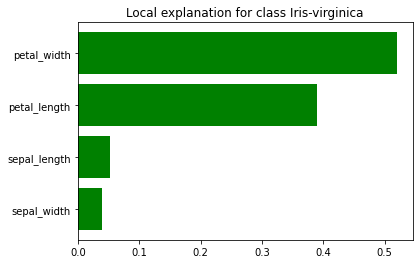

In [7]:
explanation = explainer.explain_instance(
    test_x.ravel(),
    model.predict_proba,
    num_features = 4,
    top_labels = 3
)
explanation.as_pyplot_figure(explanation.top_labels[0])
explanation.predict_proba   # probabilites from explained model

In [8]:
test_data

,sepal_length,sepal_width,petal_length,petal_width,label
118,7.7,2.6,6.9,2.3,Iris-virginica


In [9]:
print(explanation.get_prediction_for_explained_model())
print(explanation.get_prediction_for_surrogate_model())
print(explanation.get_prediction_for_surrogate_model(normalized=True))


[0, 0, 1]
[0, 0, 1]
[0.0, 0.0, 1.0]


In [10]:
print("MSE on training set:", np.array(explanation.get_losses_for_surrogate_model()))
print("MSE on cv-test  set:", np.mean(explanation.get_losses_for_cv_model(), axis=1))
print("std on cv-test  set:", np.std(explanation.get_losses_for_cv_model(), axis=1))

MSE on training set: [0.10546667 0.10546667 0.10546667]
MSE on cv-test  set: [0.10866667 0.10866667 0.10866667]
std on cv-test  set: [0.00996884 0.00996884 0.00996884]


In [11]:
explanation.get_fidelity_loss_on_kfold()

array([0.11533333, 0.11066667, 0.09      , 0.11866667, 0.10866667])

In [12]:
explanation.get_fidelity_loss_on_explanation()


0.0

In [13]:
explanation.get_fidelity_loss_on_generated_data()


0.10546666666666667

In [14]:
top_features = explanation.as_map()[explanation.top_labels[0]]
top_features

[(3, 0.5195140782187143),
 (2, 0.3894329205227728),
 (0, 0.05196573830204446),
 (1, 0.03908726295646851)]

In [15]:
second_top_features = explanation.as_map()[explanation.top_labels[1]]
second_top_features

[(3, 0.5195140782187143),
 (2, 0.3894329205227728),
 (0, 0.05196573830204446),
 (1, 0.03908726295646851)]

In [16]:
explanation.as_map()

{0: [(3, 0.5195140782187143),
  (2, 0.3894329205227728),
  (0, 0.05196573830204446),
  (1, 0.03908726295646851)],
 1: [(3, 0.5195140782187143),
  (2, 0.3894329205227728),
  (0, 0.05196573830204446),
  (1, 0.03908726295646851)],
 2: [(3, 0.5195140782187143),
  (2, 0.3894329205227728),
  (0, 0.05196573830204446),
  (1, 0.03908726295646851)]}

Update some attributes to see if probabilities would change

In [17]:
top_features = explanation.as_map()[predicted_label_id]
top_features

[(3, 0.5195140782187143),
 (2, 0.3894329205227728),
 (0, 0.05196573830204446),
 (1, 0.03908726295646851)]